<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/04_pyTorchCustomDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notebook 

How do you get your own data into PyTorch? 

One of the ways to do so is via custom datasets. 

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## 1. Get data

Our dataset is a subset of the Food101 dataset and 1000 images per class (750 training, 250 testing) 

Food101 starts with 101 different classes of food. Our dataset starts with 3 classes of food and only 10% of the images.

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary 

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if image folder doesn't exist, download
if image_path.is_dir():
  print(f"{image_path} directory already exists ... skipping download")
else:
  print(f"{image_path} directory doesn't exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data 
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak, and sushi data...")
  f.write(request.content)

f.close()

# unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory doesn't exist, creating one...
Unzipping pizza, steak, and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [3]:
import os 
def walkThroughDir(dirPath):
  """
  Walks through dirPath returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dirPath):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walkThroughDir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


In [5]:
# Setup train and testing paths
trainDir = image_path / "train"
testDir = image_path / "test"

trainDir, testDir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1. get all of the image paths
2. pick a random path using `random.choice()`
3. get the image class name `using pathlib.Path.parent.stem`
4. open the image with Python's PIL
5. show image and print metadata

In [6]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/pizza/1524655.jpg
Image class: pizza
Image height: 512
Image width: 512


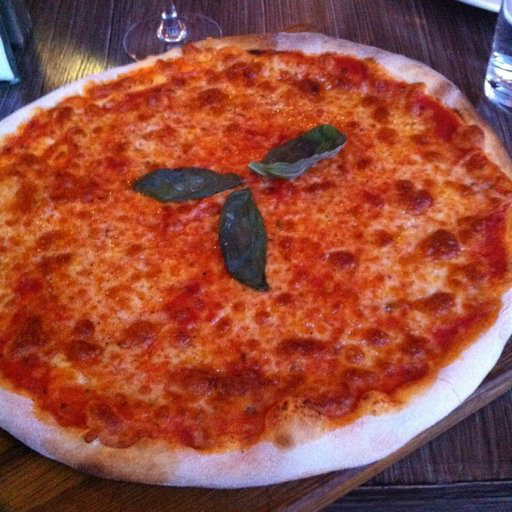

In [7]:
import random
from PIL import Image

# set seed
#random.seed(42)

# 1. get all image paths
imagePathList = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random path 
randomPath = random.choice(imagePathList)

# 3. get the image class name
imageClass = randomPath.parent.stem

# 4. open image
img = Image.open(randomPath)

# 5. print metadata
print(f"Random image path: {randomPath}")
print(f"Image class: {imageClass}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

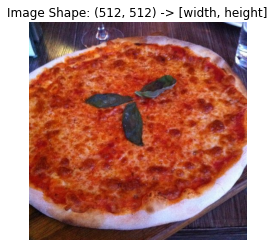

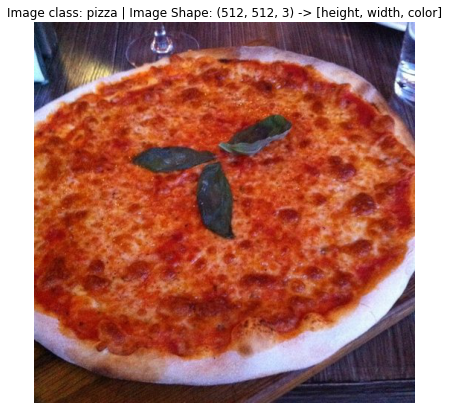

In [8]:
# visualize with matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(img);
plt.title(f"Image Shape: {img.size} -> [width, height]")
plt.axis(False);

# also turn image into an array
imgAsArray = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(imgAsArray);
plt.title(f"Image class: {imageClass} | Image Shape: {imgAsArray.shape} -> [height, width, color]");
plt.axis(False);

## 3. Transforming Data (into tensors format)

1. Turn target data into tensors (in this case, numerical representation of images) 
2. Turn it into a `torch.utils.data.Dataset` 
3. Turn Dataset into `torch.utils.data.DataLoader` - batched, iterable version of dataset


In [9]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [10]:
# write a transform for the image
dataTransform = transforms.Compose([
    # resize our images to 64,64 
    transforms.Resize(size=(64,64)),
    # flip the images randomly on the horizontal 
    transforms.RandomHorizontalFlip(p=0.5),
    # turn image into torch tensor
    transforms.ToTensor() # from PIL Image of HWC -> CHW 
])

In [11]:
dataTransform(img).shape

torch.Size([3, 64, 64])

Text(0.5, 1.0, 'Visualizing Transformed image')

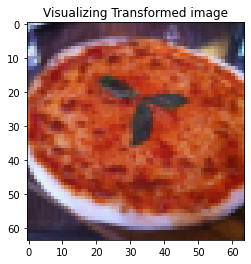

In [12]:
# Visualizing the data again
transformNumpy = dataTransform(img).numpy()

# switch axis 
transformNumpy = np.moveaxis(transformNumpy, 0, -1)

plt.imshow(transformNumpy);
plt.title(f"Visualizing Transformed image")

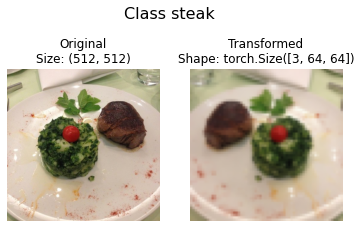

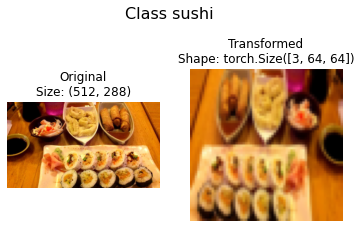

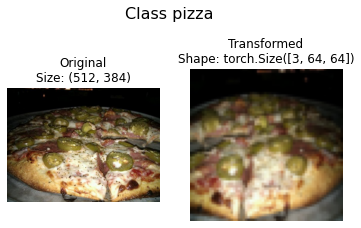

In [13]:
# Creating a function to visualize for us
def plotTransformedImage(imagePaths: list,
                         transform,
                         n=3,
                         seed=None):
  """
  Selects random images from a path of iamges and loads/transforms
  them, then plots the original vs the transformed image versions.
  """

  if seed:
    random.seed(seed)
  
  randomImagePaths = random.sample(imagePaths, k=n)

  for imagePath in randomImagePaths:
    with Image.open(imagePath) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)

      # plot original
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # plot transformed
      transformedImage = transform(f)
      ax[1].imshow(transformedImage.permute(1,2,0)) # changing shape from CHW -> HWC
      ax[1].set_title(f"Transformed\nShape: {transformedImage.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class {imagePath.parent.stem}", fontsize=16)

plotTransformedImage(imagePaths=imagePathList,
                     transform=dataTransform, 
                     n=3,
                     seed=None)


## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using  `torchvision.datasets.ImageFolder`

In [14]:
# use ImageFolder class to create dataset(s)
from torchvision import datasets

trainData = datasets.ImageFolder(root=trainDir,
                                 transform=dataTransform, # transform for the data
                                 target_transform=None) # transform for target

testData = datasets.ImageFolder(root=testDir,
                                transform=dataTransform,
                                target_transform=None)

In [15]:
# Get class names as a list
classNames = trainData.classes

# get class names as a dictionary
classDict = trainData.class_to_idx

In [16]:
# check lengths of our datasets
len(trainData), len(testData)

(225, 75)

In [17]:
# Index on the trainData dataset to get a single image and label
image, label = trainData[0]

print(f"Image tensor:\n {image}")
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Label tensor:\n {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1137, 0.1020, 0.0980,  ..., 0.1255, 0.1216, 0.1176],
         [0.1059, 0.0980, 0.0980,  ..., 0.1294, 0.1294, 0.1294],
         [0.1020, 0.0980, 0.0941,  ..., 0.1333, 0.1333, 0.1333],
         ...,
         [0.1098, 0.1098, 0.1255,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0941, 0.1098,  ..., 0.1686, 0.1647, 0.1686],
         [0.0863, 0.0863, 0.0980,  ..., 0.1686, 0.1647, 0.1647]],

        [[0.0745, 0.0706, 0.0745,  ..., 0.0588, 0.0588, 0.0588],
         [0.0706, 0.0706, 0.0745,  ..., 0.0627, 0.0627, 0.0627],
         [0.0706, 0.0745, 0.0745,  ..., 0.0706, 0.0706, 0.0706],
         ...,
         [0.1255, 0.1333, 0.1373,  ..., 0.2510, 0.2392, 0.2392],
         [0.1098, 0.1176, 0.1255,  ..., 0.2510, 0.2392, 0.2314],
         [0.1020, 0.1059, 0.1137,  ..., 0.2431, 0.2353, 0.2275]],

        [[0.0941, 0.0902, 0.0902,  ..., 0.0196, 0.0196, 0.0196],
         [0.0902, 0.0863, 0.0902,  ..., 0.0196, 0.0157, 0.0196],
         [0.0902, 0.0902, 0.0902,  ..., 0.0

Original Shape: torch.Size([3, 64, 64]) -> [color, height, width]
Permuted Shape: torch.Size([64, 64, 3]) -> [height, width, color]


Text(0.5, 1.0, 'pizza')

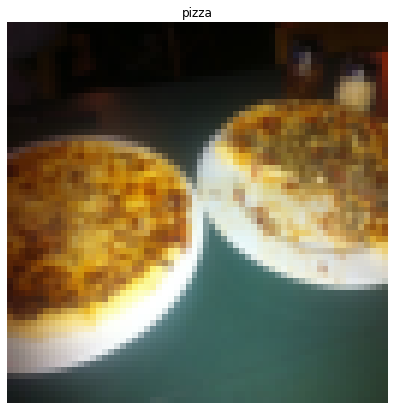

In [18]:
# Rearrange the order dimensions
imagePermute = image.permute(1, 2, 0)

# print out shape change
print(f"Original Shape: {image.shape} -> [color, height, width]")
print(f"Permuted Shape: {imagePermute.shape} -> [height, width, color]")

plt.figure(figsize=(10,7))
plt.imshow(imagePermute);
plt.axis(False);
plt.title(classNames[label])

### 4.1 Turn datasets into `DataLoader`s 

A `DataLoader` is going to make our data iterables and can customise `batch_size`

In [19]:
import os
os.cpu_count()

2

In [20]:
# Create a train DataLoader
from torch.utils.data import DataLoader

batchSize = 1

trainDataLoader = DataLoader(trainData, 
                             batch_size=batchSize,
                             num_workers=os.cpu_count(),
                             shuffle=True)

testDataLoader = DataLoader(testData,
                            batch_size=batchSize,
                            num_workers=os.cpu_count(),
                            shuffle=False)

trainDataLoader, testDataLoader

(<torch.utils.data.dataloader.DataLoader at 0x7f52605d8280>,
 <torch.utils.data.dataloader.DataLoader at 0x7f52605d8820>)

In [21]:
len(testDataLoader)

75

In [22]:
image, label = next(iter(trainDataLoader))

print(f"Image shape: {image.shape} -> [batchSize, color, height, width]")
print(f"Label shape: {label.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batchSize, color, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image Data with a Custom `Dataset`

1. load image from file
2. want to get class names from the Dataset
3. want to get classes as dictionary from Dataset

Pros: 
* Can create a `Dataset` out of almost anything
* Not limited to PyTorch pre-built `Dataset` functions

Cons:
* Even though you could create `Dataset` out of almost anything, it doesn't mean it will work...
* Using a custom `Dataset` often results in us writing more code, which could be prone to errors or performance issues

All custom datasets in PyTorch, subclass torch.utils.data.Dataset

In [23]:
import os 
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List


In [24]:
# Instance of torchvision.datasets.ImageFolder()
trainData.classes, trainData.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.1 Creating a helper function to get class names

We want a function to:
1. get the class names using `os.scandir()` to traverse a target directory 
2. raise an error if the class names aren't found (if this happens, there might be something wrong with the directory structure) 
3. turn class names into a dict and a list and return them 

In [25]:
# Setup path for target directory 
targetDirectory = trainDir 
print(f"Target Dir: {targetDirectory}")

# Get the class names from the target directory 
classNamesFound = sorted([entry.name for entry in list(os.scandir(targetDirectory))])
classNamesFound

Target Dir: data/pizza_steak_sushi/train


['pizza', 'steak', 'sushi']

In [26]:
# functionizing previous functionality 
def findClasses(directory: str) -> Tuple[List[str], Dict[str, list]]:
  """
  Finds the class folder names in a target directory.
  """
  # 1. get the class names by scanning the target directory 
  classes = sorted(entry.name for entry in list(os.scandir(directory)) if entry.is_dir())

  # 2. raise an error if clsas names could not be found
  if not classes: 
    raise FileNotFoundError(f"Couldn't find any classes in {directory}... please check file structure.")
  
  # 3. create a dictionary of index labels 
  classToIdx = {className: i for i, className in enumerate(classes)}

  return classes, classToIdx

In [27]:
findClasses(targetDirectory)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

### 5.2 Create a custom `Dataset` to replicate `ImageFolder`

to create our own custom dataset, we want to: 
1. subclass `torch.utils.data.Dataset`
2. init our subclass with a target directory and transform 
3. create attributes:
  * paths - paths to our images
  * transform - the transform we'd like to use
  * classes - a list of the target classes 
  * classToIdx - a dict of the target classes mapped to integer labels 
4. create a function to `load_images()`
5. overwrite the `__len__()` method to return the length of our dataset
6. overwrite the `__getitem__()` method to return a given sample when passed an index 

In [28]:
# 0. write a custom dataset class
from torch.utils.data import Dataset

# 1. subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. initialize our custom dataset
  def __init__(self, targetDir: str, transform=None):
    super().__init__() 

    # 3. create class attributes

    # get all image paths 
    self.paths = list(pathlib.Path(targetDir).glob("*/*.jpg"))

    # setup transforms
    self.transform = transform

    # classes
    self.classes, self.classToIdx = findClasses(targetDir)

  # 4. create a function to load images
  def loadImage(self, index: int) -> Image.Image:
    """
    Opens an image via a path and returns it.
    """
    imagePath = self.paths[index]
    return Image.open(imagePath)

  # 5. overwrite __len__()
  def __len__(self) -> int:
    """
    Returns the total number of samples
    """
    return len(self.paths)

  # 6. overwrite __getitem__()
  def __getitem__(self, index: int) -> Tuple[torch.tensor, int]:
    """
    Returns one sample of data, data and label (X, y). 
    """
    img = self.loadImage(index)
    className = self.paths[index].parent.name # expects path in format: data_folder/class_name/image.jpg
    classIdx = self.classToIdx[className]

    # transform if necessary 
    if self.transform:
      return self.transform(img), classIdx
    else:
      return img, classIdx

In [29]:
# Create a new transform? 
trainTransform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

testTransform = transforms.Compose([
    transforms.Resize(size=(64,64)),
    transforms.ToTensor()
])

customTrainData = ImageFolderCustom(targetDir=trainDir,
                                          transform=trainTransform)

customTestData = ImageFolderCustom(targetDir=testDir,
                                         transform=testTransform)

In [30]:
len(customTrainData), len(customTestData)

(225, 75)

In [31]:
customTrainData.classes, trainData.classes

(['pizza', 'steak', 'sushi'], ['pizza', 'steak', 'sushi'])

In [32]:
customTrainData.classToIdx, trainData.class_to_idx

({'pizza': 0, 'steak': 1, 'sushi': 2}, {'pizza': 0, 'steak': 1, 'sushi': 2})

In [33]:
# check for equality between original ImageFolder Dataset and ImageFolderCustomDataset
print(customTrainData.classes == trainData.classes)
print(customTrainData.classToIdx == trainData.class_to_idx)

True
True


### 5.3 Create a function to display random images

1. take in a dataset and class names and how many images to visualize
2. to prevent the display from getting out of hand, cap the num of images to see at 10 
3. set random seed for reproducibility 
4. list of random sample indexes from the target dataset
5. setup matplotlib plot
6. loop through random sample indeces and plot them with matplotlib 
7. make sure dimensions of our images line up with matplotlib (HWC)

In [34]:
# 1. create a function to take in dataset
def displayRandomImages(dataset: torch.utils.data.Dataset,
                        classes: List[str]=None, 
                        n: int = 10,
                        displayShape: bool=True,
                        seed: int=None):
   
  # 2. adjust display if n is too high
  if n >= 10:
    n = 10
    displayShape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display.")
  
  # 3. set random seed for reproducibility
  if seed:
    random.seed(seed)

  # 4. get random sample indeces
  randomSampleIdx = random.sample(range(len(dataset)), k=n)

  # 5. setup matplotlib plot
  plt.figure(figsize=(16,8))

  # 6. loop through random indeces and plot
  for i, targSample in enumerate(randomSampleIdx): 
    targImage, targLabel = dataset[targSample][0], dataset[targSample][1]

    # 7. adjust tensor dimensions for plotting
    targImageAdjust = targImage.permute(1,2,0) # c,h,w -> h,w,c

    plt.subplot(1, n, i+1)

    plt.imshow(targImageAdjust);
    plt.axis(False);
    if classes:
      title=f"Class: {classes[targLabel]}"
      if displayShape:
        title=title + f"\nshape: {targImageAdjust.shape}"
      
      plt.title(title)

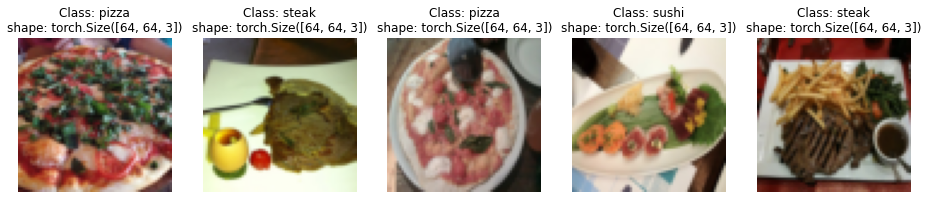

In [35]:
# Display random images from ImageFolder created dataset
displayRandomImages(dataset=trainData,
                    n=5,
                    classes=classNames,
                    seed=None)

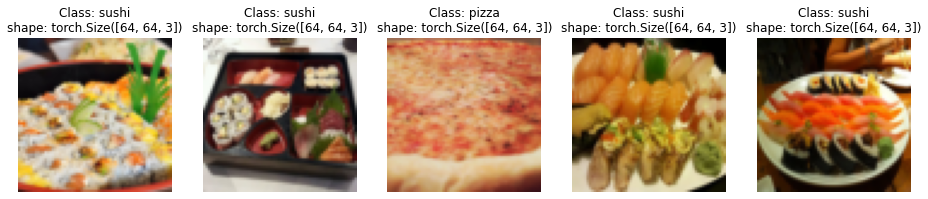

In [36]:
# Display random images from custom image folder dataset
displayRandomImages(dataset=customTrainData,
                    n=5,
                    classes=classNames,
                    seed=None)

### 5.4 Turn custom loaded images in `DataLoader`s

In [37]:
from torch.utils.data import DataLoader

batchSize = 1

customTrainDataLoader = DataLoader(dataset=customTrainData,
                                   batch_size=batchSize,
                                   num_workers=0,
                                   shuffle=True)

customTestDataLoader = DataLoader(dataset=customTestData,
                                  batch_size=batchSize,
                                  num_workers=0,
                                  shuffle=False)

customTrainDataLoader, customTestDataLoader

(<torch.utils.data.dataloader.DataLoader at 0x7f526037f7f0>,
 <torch.utils.data.dataloader.DataLoader at 0x7f526037f760>)

In [38]:
# get image and label from custom dataloader 
imageCustom, labelCustom = next(iter(customTrainDataLoader))

imageCustom.shape, labelCustom.shape

(torch.Size([1, 3, 64, 64]), torch.Size([1]))

## 6. Other forms of transforms (data augmentation)

data agumentation - artificially adding diversity to training data - also can artificially increase the amount of data 

In the case of image data, this may mean applying various images filters to the training images

This practice hopefullly results in a model that's more generalizable to other data

Let's take a look at one particular type of data augmentation used to train PyTorch vision models to state of the art levels... papers have come out to show that this can improve your model by ~5% 

In [39]:
# Let's look at trivial augment 
from torchvision import transforms 

trainTransform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

testTransform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor()
])

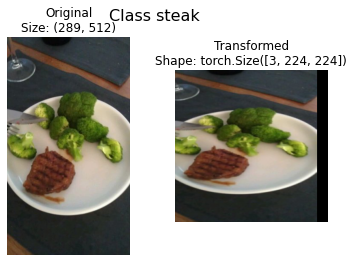

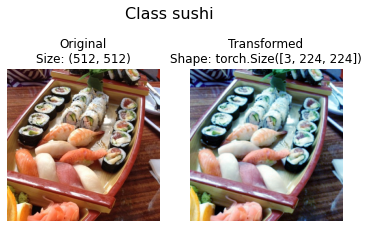

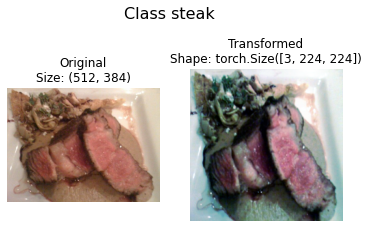

In [40]:
# Get all image paths
imagePathList = list(image_path.glob("*/*/*.jpg"))

plotTransformedImage(imagePaths=imagePathList,
                     transform=trainTransform,
                     n=3,
                     seed=None)

## 7. Model 0: TinyVGG without data augmentation 

Replicate TinyVGG architecture 

### 7.1 Creating transforms and loading data for Model 0 

recreate for practice

In [41]:
 # Create simple transform 
simpleTransform = transforms.Compose([transforms.Resize(size=(64,64)),
                                      transforms.ToTensor()])

In [42]:
# 1. Load and transform data
from torchvision import datasets

trainDataSimple = datasets.ImageFolder(root=trainDir,
                                       transform=simpleTransform, 
                                       target_transform=None)

testDataSimple = datasets.ImageFolder(root=testDir, 
                                      transform=simpleTransform,
                                      target_transform=None)

In [43]:
# 2. turn datasets into dataloader
import os
from torch.utils.data import DataLoader

# setup batch size and number of works
batchSize = 32
num_workers = os.cpu_count()

# create dataloaders
trainDataLoaderSimple = DataLoader(dataset=trainDataSimple,
                                   batch_size=batchSize,
                                   shuffle=True,
                                   num_workers=num_workers)

testDataLoaderSimple = DataLoader(dataset=testDataSimple,
                                  batch_size=batchSize,
                                  shuffle=False,
                                  num_workers=num_workers)

In [44]:
# 3. build TinyVGG model 
from torch import nn

class TinyVGG(nn.Module):
  def __init__(self, inputShape: int, outputShape: int, hiddenUnits: int) -> None:
    super().__init__()

    self.convBlock1 = nn.Sequential(
        nn.Conv2d(in_channels=inputShape, 
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hiddenUnits,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.convBlock2 = nn.Sequential(
        nn.Conv2d(in_channels=hiddenUnits, 
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hiddenUnits,
                  out_channels=hiddenUnits,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hiddenUnits*13*13,
                  out_features=outputShape)
    )

  def forward(self, x):
    #print(f"Shape before convolution block 1: {x.shape}")
    x = self.convBlock1(x)
    #print(f"Shape after convolution block 1: {x.shape}")
    x = self.convBlock2(x)
    #print(f"Shape after convolution block 2: {x.shape}")
    x = self.classifier(x)
    #print(f"Shape after classifier: {x.shape}")
    return x 




In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
modelSimple = TinyVGG(inputShape=3,
                      hiddenUnits=10,
                      outputShape=len(classNames)).to(device)

### 7.3 Try a forward pass on a single image (to test the model)

In [46]:
# get a single image batch
image_batch, label_batch = next(iter(trainDataLoaderSimple))

image_batch, label_batch = image_batch.to(device), label_batch.to(device)
image_batch.shape

torch.Size([32, 3, 64, 64])

In [47]:
modelSimple.eval()
with torch.inference_mode():
  test = modelSimple(image_batch)

In [48]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [49]:
from torchinfo import summary
summary(modelSimple, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 10, 62, 62]           280
│    └─ReLU: 2-2                         [1, 10, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 10, 60, 60]           910
│    └─ReLU: 2-4                         [1, 10, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 10, 30, 30]           --
├─Sequential: 1-2                        [1, 10, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 10, 28, 28]           910
│    └─ReLU: 2-7                         [1, 10, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 10, 26, 26]           910
│    └─ReLU: 2-9                         [1, 10, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 10, 13, 13]           --
├─Sequentia

### 7.5. Functionizing train and test steps 

* `trainStep()` - takes in a model and dataloader and trains the model on the dataloader
* `testStep()` - takes in a model and dataloader and evaluated the model on the dataloader

In [84]:
# create trainStep()
def trainStep(model: torch.nn.Module,
              dataLoader: torch.utils.data.DataLoader,
              lossFn: torch.nn.Module,
              optimizer: torch.optim.Optimizer,
              device=device):
  
  # set model to train mode
  model.train()

  loss, acc = 0, 0
  
  for batches, (X, y) in enumerate(dataLoader):
    X, y = X.to(device), y.to(device)
    
    # 1. forward pass
    trainLogits = model(X)

    trainLabels = torch.softmax(trainLogits, dim=1).argmax(dim=1)

    # 2. compute the loss 
    trainLoss = lossFn(trainLogits, y)
    loss += trainLoss 
    
    acc += (trainLabels==y).sum().item()/len(trainLogits)

    # 3. optimizer zero grad
    optimizer.zero_grad()

    # 4. backward pass 
    trainLoss.backward()

    # 5. optimizer step
    optimizer.step()
  
  loss /= batches 
  acc /= batches 

  return loss, acc




In [85]:
def testStep(model: torch.nn.Module,
             dataLoader: torch.utils.data.DataLoader,
             lossFn: torch.nn.Module,
             device=device):
  
  # model to eval mode
  model.eval()

  loss, acc = 0, 0

  with torch.inference_mode():

    for batch, (X, y) in enumerate(dataLoader):

      if device:
        X, y = X.to(device), y.to(device)
      
      testLogits = model(X)

      testPreds = torch.softmax(testLogits, dim=1).argmax(dim=1)

      loss += lossFn(testLogits, y)
      acc += (testPreds==y).sum().item()/len(testLogits)

    loss /= len(dataLoader)
    acc /= len(dataLoader)
  
  return loss, acc

### 7.6 Creating a `train()` function to combine `trainStep()` and `testStep()`

In [112]:
# create full training function
from tqdm.auto import tqdm 

def train(model: torch.nn.Module,
          trainDataLoader: torch.utils.data.DataLoader,
          testDataLoader: torch.utils.data.DataLoader,
          lossFn: torch.nn.Module,
          optimizer: torch.optim.Optimizer,
          epochs: int = 5,
          device=device):
  
  # create empty results
  results = {"trainLoss": [],
             "trainAcc": [],
             "testLoss": [],
             "testAcc": []}

  # loop
  for epoch in tqdm(range(epochs), desc=f"training model: {model.__class__.__name__}"):
    
    trainLoss, trainAcc = trainStep(model=model,
                                    dataLoader=trainDataLoader,
                                    lossFn=lossFn, 
                                    optimizer=optimizer,
                                    device=device)
    
    testLoss, testAcc = testStep(model=model,
                                 dataLoader=testDataLoader,
                                 lossFn=lossFn,
                                 device=device)
    
    print(f"------- Epoch {epoch} -------")
    print(f"\nTrain Loss: {trainLoss:.3f} | Train Accuracy: {trainAcc*100:.2f}%")
    print(f"\nTest Loss: {testLoss:.3f} | Test Accuracy: {testAcc*100:.2f}%")
    results["trainLoss"].append(trainLoss.item())
    results["trainAcc"].append(trainAcc)
    results["testLoss"].append(testLoss.item())
    results["testAcc"].append(testAcc)

  return results



### 7.7 Train and evaluate model 0

In [133]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# number of epochs
EPOCHS = 10

# recreate an instance of TinyVGG
model0 = TinyVGG(inputShape=3,outputShape=len(classNames),hiddenUnits=10).to(device)

In [134]:
next(model0.parameters()).device

device(type='cuda', index=0)

In [135]:
# create a loss function and optimizer
lossFn = nn.CrossEntropyLoss()

optimizer = torch.optim.Adam(params=model0.parameters(),
                            lr=0.0001)

In [136]:
from timeit import default_timer as timer
startTime = timer()

# Train model 0 
model0Results = train(model=model0,
                      trainDataLoader=trainDataLoaderSimple,
                      testDataLoader=testDataLoaderSimple,
                      optimizer=optimizer,
                      lossFn=lossFn,
                      epochs=EPOCHS)

endTime = timer() 

totalTime = endTime - startTime

print(f"Results:\n{model0Results}")
print(f"Total Time:\n{totalTime:.3f} seconds")

training model: TinyVGG:   0%|          | 0/10 [00:00<?, ?it/s]

------- Epoch 0 -------

Train Loss: 1.256 | Train Accuracy: 34.82%

Test Loss: 1.098 | Test Accuracy: 26.04%
------- Epoch 1 -------

Train Loss: 1.257 | Train Accuracy: 34.82%

Test Loss: 1.094 | Test Accuracy: 30.11%
------- Epoch 2 -------

Train Loss: 1.253 | Train Accuracy: 48.66%

Test Loss: 1.094 | Test Accuracy: 53.12%
------- Epoch 3 -------

Train Loss: 1.257 | Train Accuracy: 32.14%

Test Loss: 1.092 | Test Accuracy: 54.17%
------- Epoch 4 -------

Train Loss: 1.252 | Train Accuracy: 47.77%

Test Loss: 1.093 | Test Accuracy: 57.29%
------- Epoch 5 -------

Train Loss: 1.251 | Train Accuracy: 49.11%

Test Loss: 1.090 | Test Accuracy: 54.17%
------- Epoch 6 -------

Train Loss: 1.249 | Train Accuracy: 46.43%

Test Loss: 1.085 | Test Accuracy: 54.17%
------- Epoch 7 -------

Train Loss: 1.258 | Train Accuracy: 32.14%

Test Loss: 1.081 | Test Accuracy: 54.17%
------- Epoch 8 -------

Train Loss: 1.259 | Train Accuracy: 32.14%

Test Loss: 1.084 | Test Accuracy: 54.17%
------- Ep